In [6]:
import numpy as np
import pandas as pd
import cudf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# Stel de data in
X_tr = pd.read_csv('alle_kranten_X_train.csv')
X_te = pd.read_csv('alle_kranten_X_test.csv')
y_tr = pd.read_csv('alle_kranten_y_train.csv')
y_te = pd.read_csv('alle_kranten_y_test.csv')

# Clip de data om extreme waarden te vermijden
X_tr_clipped = np.clip(X_tr, -500, 500)
X_te_clipped = np.clip(X_te, -500, 500)
y_tr_clipped = np.clip(y_tr, 1, None)  # Zorg ervoor dat geen waarde 0 of negatief is
y_te_clipped = np.clip(y_te, 1, None)

# Maak een scaler object
scaler = StandardScaler()

# Schaal de data
X_tr_scaled = scaler.fit_transform(X_tr_clipped)
X_te_scaled = scaler.transform(X_te_clipped)
y_tr_scaled = scaler.fit_transform(y_tr_clipped.values.reshape(-1, 1))
y_te_scaled = scaler.transform(y_te_clipped.values.reshape(-1, 1))

# Log-transformatie
y_log = np.log1p(y_tr_scaled)

# Initialiseer en train het model
model = XGBRegressor(random_state=42)
model.fit(X_tr_scaled, y_log)

# Maak voorspellingen
y_pred_log = model.predict(X_te_scaled)

# Beperk de voorspellingen na exp1 om overflows te voorkomen
y_pred_log = np.clip(y_pred_log, -500, 500)
y_pred = np.expm1(y_pred_log)

# Evaluatie van het model
mse = mean_squared_error(np.expm1(y_te_scaled), y_pred)
rmse = mse ** 0.5

# Print de resultaten
print(f"RMSE na log-transformatie: {rmse}")

RMSE na log-transformatie: 602.5378555399827


In [7]:
import numpy as np
# Gewicht geven aan hogere waarden
weights = np.where(y_tr_scaled > 300, 2.0, 1.0)  # Dubbele gewicht voor hogere waarden

# Train XGBoost met sample gewichten
model.fit(X_tr_scaled, y_tr_scaled, sample_weight=weights)

# Evaluatie
y_pred = model.predict(X_te_scaled)
mse = mean_squared_error(y_te_scaled, y_pred)
rmse = mse ** 0.5
print(f"RMSE met gewichten: {rmse}")

RMSE met gewichten: 0.8087071971118904


In [8]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
}

grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1
)

grid_search.fit(X_tr_scaled, y_tr_scaled, sample_weight=weights)
print("Beste parameters:", grid_search.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Beste parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


In [9]:
best_model = XGBRegressor(
    learning_rate=0.1,
    max_depth=7,
    n_estimators=200,
    random_state=42
)

# Train opnieuw
best_model.fit(X_tr_scaled, y_tr_scaled, sample_weight=weights)

# Voorspellingen maken
y_pred = best_model.predict(X_te_scaled)

# Evaluatie
mse = mean_squared_error(y_te_scaled, y_pred)
rmse = mse ** 0.5
print(f"RMSE met beste parameters: {rmse}")

RMSE met beste parameters: 0.8001769317893362


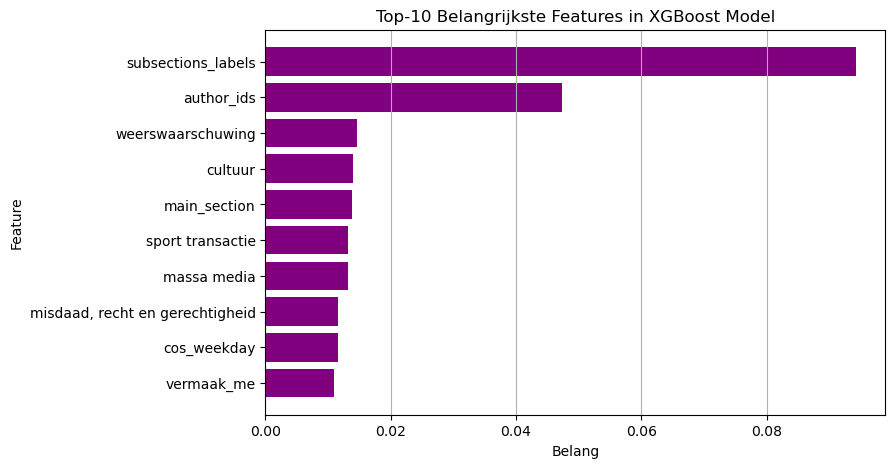

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Haal de echte feature namen uit je dataset
feature_importance = best_model.feature_importances_  # Haal de werkelijke feature importance waarden
feature_names = X_tr.columns  # Gebruik de kolomnamen van de dataset

# Maak een dataframe en sorteer op belang
feature_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
feature_df = feature_df.sort_values(by="Importance", ascending=False)

# Selecteer de top-10 belangrijkste features
top_features = feature_df.head(10)

# Maak de grafiek
plt.figure(figsize=(8, 5))
plt.barh(top_features["Feature"], top_features["Importance"], color="purple")
plt.xlabel("Belang")
plt.ylabel("Feature")
plt.title("Top-10 Belangrijkste Features in XGBoost Model")
plt.gca().invert_yaxis()
plt.grid(True, axis="x")
plt.show()

